In [2]:
%pip install alpha_vantage
%pip install arch


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from pair_trading_foundations.utils import GetSP500Data
from arch.unitroot import engle_granger, ADF
from alpha_vantage.timeseries import TimeSeries
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
import pandas as pd
import numpy as np
import warnings
# The yfinance module has some deprecation warning
warnings.filterwarnings('ignore')

/Users/michaeltay/miniforge3/lib/python3.9/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


[*********************100%%**********************]  3 of 3 completed

Price       Adj Close                            Close                        \
Ticker           AAPL      GOOGL       MSFT       AAPL      GOOGL       MSFT   
Date                                                                           
2013-12-02  17.237246  26.388388  32.377075  19.686787  26.388388  38.450001   
2013-12-03  17.709114  26.357859  32.259182  20.225714  26.357859  38.310001   
2013-12-04  17.667831  26.480982  32.789680  20.178572  26.480982  38.939999   
2013-12-05  17.758522  26.459961  31.998148  20.282143  26.459961  38.000000   
2013-12-06  17.512110  26.773523  32.301296  20.000713  26.773523  38.360001   

Price            High                              Low                        \
Ticker           AAPL      GOOGL       MSFT       AAPL      GOOGL       MSFT   
Date                                                                           
2013-12-02  20.154642  26.685434  38.779999  19.672144  26.295296  38.060001   
2013-12-03  20.227858  26.612614  38.49

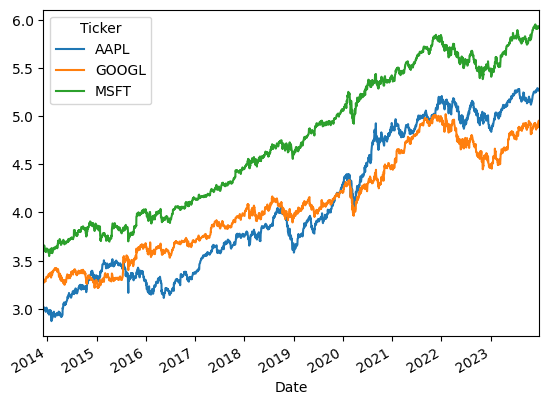

In [36]:
def get_sp500_symbols():
    sp500_symbols = ['AAPL', 'MSFT', 'GOOGL']  # Have feed list of S&P 500 component symbols
    return sp500_symbols

if __name__ == '__main__':
    # get all stock info interested
    data_frame = pdr.get_data_yahoo(get_sp500_symbols(), start='2013-12-01', end='2023-12-31')
    
    print(data_frame.head())

    # Filter by open prices
    log_price = np.log(data_frame['Open'])
    ax = log_price.plot()
    xl = ax.set_xlim(log_price.index.min(), log_price.index.max())

In [57]:
# Dicker-fuller test for APPL, fail to reject the null hypothesis p-value > 0.05
ADF(log_price.AAPL, trend="c")

Test Statistic,-0.371
P-value,0.915
Lags,6


In [100]:
# Dicker-fuller test for diff(1,APPL), reject the null hypothesis p-value < 0.05, trend is stationary
ADF(log_price.AAPL.diff(periods=1).dropna(), trend="c")

Test Statistic,-55.218
P-value,0.000
Lags,0


In [101]:
# Dicker-fuller test for GOOGL, fail to reject the null hypothesis p-value > 0.05
ADF(log_price.GOOGL, trend="c")

Test Statistic,-0.644
P-value,0.861
Lags,4


In [102]:
# Dicker-fuller test for diff(1,GOOGL), reject the null hypothesis p-value < 0.05, trend is stationary
ADF(log_price.GOOGL.diff(periods=1).dropna(), trend="c")

Test Statistic,-26.926
P-value,0.000
Lags,3


In [106]:
# Dicker-fuller test for MSFT, fail to reject the null hypothesis p-value > 0.05
ADF(log_price.MSFT, trend="c")

Test Statistic,-0.301
P-value,0.925
Lags,2


In [107]:
# Dicker-fuller test for diff(1,GOOGL), reject the null hypothesis p-value < 0.05, trend is stationary
ADF(log_price.MSFT.diff(periods=1).dropna(), trend="c")

Test Statistic,-38.969
P-value,0.000
Lags,1


In [108]:
# Michael: APPL & MSFT looks cointegrated, p-value < 0.05, but fail the ADF test
eg_test = engle_granger(log_price.AAPL.diff(periods=1).dropna(), log_price.MSFT.diff(periods=1).dropna(), trend="n")
eg_test

Test Statistic,-53.154
P-value,0.000
ADF Lag length,0
Estimated Root ρ (γ+1),-0.054


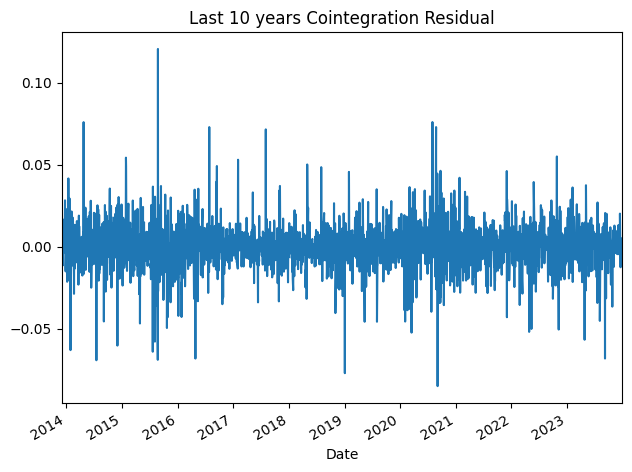

In [109]:
# Michael: Plot the residuals for cointegration 
fig = eg_test.plot()
ax = fig.get_axes()[0]
title = ax.set_title("Last 10 years Cointegration Residual")